# Notebook 10 — Pipeline **tiktoken** + CBoW com **PyTorch Embedding**

Objetivo: repetir a ideia do Notebook 09 (tokenização + CBoW + inspeção de embeddings), mas agora usando:

- **Tokenização BPE pronta** via `tiktoken` (GPT-2 encoding)
- **Embeddings** via `torch.nn.Embedding` (sem one-hot manual)

Observação importante: o vocabulário do `tiktoken` (GPT-2) é grande (~50k). Para manter o treino leve, vamos **tokenizar com tiktoken**, mas **remapear** os IDs para um vocabulário compacto apenas com os tokens que aparecem no nosso corpus.

## 0) Setup

In [1]:
# Se necessário, instale:
# !pip -q install tiktoken


import random

import matplotlib.pyplot as plt
import numpy as np
import tiktoken
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

## Verificação da presença de GPU / device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


## Fixando seed para reproducibilidade

In [3]:
def seed_all(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


seed_all(42)

## Função auxiliar: PCA 2D (sem sklearn) + plot

In [4]:
def pca_2d(x: np.ndarray) -> np.ndarray:
    """Reduz para 2D via PCA usando SVD (sem sklearn)."""
    if x.ndim != 2:
        raise ValueError("x deve ser 2D (n_amostras, n_features).")
    x0 = x - x.mean(axis=0, keepdims=True)
    # SVD: x0 = U S Vt
    _, _, vt = np.linalg.svd(x0, full_matrices=False)
    # componentes principais
    pcs = vt[:2].T  # (n_features, 2)
    return x0 @ pcs  # (n_amostras, 2)


def plot_embeddings_2d(
    token_strs: list[str],
    emb_2d: np.ndarray,
    title: str = "Embeddings (PCA 2D)",
    max_points: int = 120,
) -> None:
    """Plota embeddings em 2D com rótulos (limitado para não poluir)."""
    if len(token_strs) != emb_2d.shape[0]:
        raise ValueError("token_strs e emb_2d precisam ter o mesmo n de pontos.")

    n = min(len(token_strs), max_points)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(emb_2d[:n, 0], emb_2d[:n, 1])
    for i in range(n):
        s = token_strs[i].replace("\n", "\\n")
        ax.annotate(s, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=9)
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    plt.show()

## 1) Tokenizador `tiktoken` (BPE pronto)

In [5]:
# Encoding do GPT-2 (BPE)
tokenizer = tiktoken.get_encoding("gpt2")

# Teste rápido
texto_teste = "Olá! O gato sobe no tapete."
ids_teste = tokenizer.encode(texto_teste)
print("Texto:", texto_teste)
print("IDs:", ids_teste[:20], "...")
print("Decode (round-trip):", tokenizer.decode(ids_teste))

Texto: Olá! O gato sobe no tapete.
IDs: [30098, 6557, 0, 440, 308, 5549, 523, 1350, 645, 9814, 14471, 13] ...
Decode (round-trip): Olá! O gato sobe no tapete.


## 2) Corpus de exemplo (igual ao Notebook 09)

In [6]:
corpus = [
    # Gato
    "O gato sobe no tapete.",
    "O gato desce do tapete.",
    "O gato sobe na mesa.",
    "O gato desce da mesa.",
    # Cachorro
    "O cachorro sobe no tapete.",
    "O cachorro desce do tapete.",
    "O cachorro sobe na mesa.",
    "O cachorro desce da mesa.",
    # Aranha
    "A aranha sobe na parede.",
    "A aranha desce da parede.",
    # Objetos
    "O tapete fica no chão.",
    "A mesa fica no chão.",
    "A parede fica no quarto.",
]

print("N frases:", len(corpus))
print("Exemplo:", corpus[0])

N frases: 13
Exemplo: O gato sobe no tapete.


## 3) Tokenizando o corpus com `tiktoken` (encode)

Vamos tokenizar **por frase**, para não misturar contexto entre frases.

In [7]:
sequencias_raw_ids: list[list[int]] = [tokenizer.encode(frase) for frase in corpus]

# Métricas rápidas
n_tokens_total = sum(len(s) for s in sequencias_raw_ids)
print("Total de tokens (somando todas as frases):", n_tokens_total)

print("\nExemplo de tokenização (primeira frase):")
print("Frase:", corpus[0])
print("IDs:", sequencias_raw_ids[0])
print(
    "Tokens (decode token-a-token):",
    [tokenizer.decode([i]) for i in sequencias_raw_ids[0]],
)

Total de tokens (somando todas as frases): 130

Exemplo de tokenização (primeira frase):
Frase: O gato sobe no tapete.
IDs: [46, 308, 5549, 523, 1350, 645, 9814, 14471, 13]
Tokens (decode token-a-token): ['O', ' g', 'ato', ' so', 'be', ' no', ' tap', 'ete', '.']


## 4) Remapeando IDs do `tiktoken` para um vocabulário compacto

O `tiktoken` tem ~50k tokens. Para treinar rápido, vamos:

1. Coletar todos os IDs que aparecem no corpus
2. Criar um `raw_id -> new_id` (0..V-1)
3. Guardar também `new_id -> raw_id` e `new_id -> token_str` (para inspeção)

Isso mantém a **tokenização tiktoken**, mas deixa o modelo leve.

In [8]:
# 1) vocabulário observado no corpus
raw_vocab_ids = sorted(set(i for seq in sequencias_raw_ids for i in seq))
vocab_size = len(raw_vocab_ids)
print("Vocab compacto (tokens presentes no corpus):", vocab_size)

# 2) mapeamentos
raw_id_to_new: dict[int, int] = {rid: j for j, rid in enumerate(raw_vocab_ids)}
new_to_raw_id: dict[int, int] = {j: rid for rid, j in raw_id_to_new.items()}
new_id_to_token_str: dict[int, str] = {
    j: tokenizer.decode([new_to_raw_id[j]]) for j in range(vocab_size)
}

# 3) remapeia sequências
sequencias_ids: list[list[int]] = [
    [raw_id_to_new[rid] for rid in seq] for seq in sequencias_raw_ids
]

print("\nExemplo de remapeamento:")
print("raw IDs:", sequencias_raw_ids[0])
print("new IDs:", sequencias_ids[0])
print("tokens:", [new_id_to_token_str[i] for i in sequencias_ids[0]])

Vocab compacto (tokens presentes no corpus): 33

Exemplo de remapeamento:
raw IDs: [46, 308, 5549, 523, 1350, 645, 9814, 14471, 13]
new IDs: [2, 12, 25, 16, 22, 19, 26, 29, 0]
tokens: ['O', ' g', 'ato', ' so', 'be', ' no', ' tap', 'ete', '.']


## 5) Gerando dados (contexto → alvo) para CBoW usando IDs

Mesma ideia do Notebook 09: para cada token-alvo, usamos uma janela fixa de contexto e tentamos prever o token central (CBOW).

In [9]:
def gerar_dados_cbow(
    sequencias: list[list[int]],
    janela: int = 2,
) -> list[tuple[list[int], int]]:
    """
    Gera pares (contexto, alvo) para CBoW a partir de sequências de IDs.

    Parâmetros:
    ----------
    sequencias : list[list[int]]
        Uma lista de sequências (uma por frase).
    janela : int, default=2
        Tamanho da janela em cada lado.

    Retorno:
    -------
    list[tuple[list[int], int]]
        Lista de pares: (contexto_ids, alvo_id).
        - contexto_ids tem tamanho 2*janela
        - alvo_id é o token central
    """
    if not isinstance(janela, int) or janela <= 0:
        raise ValueError("`janela` deve ser um inteiro > 0.")

    dados: list[tuple[list[int], int]] = []
    for ids in sequencias:
        if len(ids) < (2 * janela + 1):
            continue
        for i in range(janela, len(ids) - janela):
            contexto = [ids[i + j] for j in range(-janela, janela + 1) if j != 0]
            alvo = ids[i]
            dados.append((contexto, alvo))
    return dados


def mostrar_conjunto_treino(
    dados: list[tuple[list[int], int]],
    id_to_token: dict[int, str],
    limite: int = 10,
) -> None:
    print("\nExemplos do conjunto de treino (CBOW):\n")
    for i, (ctx, y) in enumerate(dados[:limite]):
        ctx_toks = [id_to_token[t] for t in ctx]
        y_tok = id_to_token[y]
        print(f"{i:02d}  contexto={ctx_toks}  ->  alvo={y_tok}")


dados_treino = gerar_dados_cbow(sequencias_ids, janela=2)
print("Total de exemplos de treino gerados:", len(dados_treino))
mostrar_conjunto_treino(dados_treino, new_id_to_token_str, limite=10)

Total de exemplos de treino gerados: 78

Exemplos do conjunto de treino (CBOW):

00  contexto=['O', ' g', ' so', 'be']  ->  alvo=ato
01  contexto=[' g', 'ato', 'be', ' no']  ->  alvo= so
02  contexto=['ato', ' so', ' no', ' tap']  ->  alvo=be
03  contexto=[' so', 'be', ' tap', 'ete']  ->  alvo= no
04  contexto=['be', ' no', 'ete', '.']  ->  alvo= tap
05  contexto=['O', ' g', ' des', 'ce']  ->  alvo=ato
06  contexto=[' g', 'ato', 'ce', ' do']  ->  alvo= des
07  contexto=['ato', ' des', ' do', ' tap']  ->  alvo=ce
08  contexto=[' des', 'ce', ' tap', 'ete']  ->  alvo= do
09  contexto=['ce', ' do', 'ete', '.']  ->  alvo= tap


## 6) Dataset + DataLoader

In [10]:
class CBOWDataset(Dataset):
    def __init__(self, dados: list[tuple[list[int], int]]):
        self.dados = dados

    def __len__(self) -> int:
        return len(self.dados)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        ctx, y = self.dados[idx]
        return torch.tensor(ctx, dtype=torch.long), torch.tensor(y, dtype=torch.long)


def collate_cbow(batch):
    # batch: List[(ctx_tensor (C,), y_tensor ())]
    ctxs = torch.stack([b[0] for b in batch], dim=0)  # (B, C)
    ys = torch.stack([b[1] for b in batch], dim=0)  # (B,)
    return ctxs, ys


batch_size = 32
loader = DataLoader(
    CBOWDataset(dados_treino),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_cbow,
    num_workers=0,  # em notebook, 0 costuma ser mais estável
)

ctx_batch, y_batch = next(iter(loader))
print("ctx_batch:", ctx_batch.shape, "y_batch:", y_batch.shape)

ctx_batch: torch.Size([32, 4]) y_batch: torch.Size([32])


## 7) Modelo CBoW com `nn.Embedding` + treino

Diferença-chave vs. Notebook 09:

- Antes: one-hot manual + matrizes W/U
- Agora: `nn.Embedding` faz o lookup do embedding e `nn.Linear` projeta para o vocabulário

Pipeline do forward:

1. `emb = embedding(context_ids)` → (B, C, D)
2. `emb_mean = emb.mean(dim=1)` → (B, D)
3. `logits = linear(emb_mean)` → (B, V)
4. Loss: `CrossEntropy(logits, target)`

Época 001/500 | loss médio: 3.6595
Época 010/500 | loss médio: 3.4289
Época 020/500 | loss médio: 3.2263
Época 030/500 | loss médio: 3.0435
Época 040/500 | loss médio: 2.8883
Época 050/500 | loss médio: 2.7175
Época 060/500 | loss médio: 2.5624
Época 070/500 | loss médio: 2.4509
Época 080/500 | loss médio: 2.3166
Época 090/500 | loss médio: 2.1469
Época 100/500 | loss médio: 2.0598
Época 110/500 | loss médio: 1.9550
Época 120/500 | loss médio: 1.7647
Época 130/500 | loss médio: 1.7267
Época 140/500 | loss médio: 1.6071
Época 150/500 | loss médio: 1.5471
Época 160/500 | loss médio: 1.4836
Época 170/500 | loss médio: 1.4289
Época 180/500 | loss médio: 1.3832
Época 190/500 | loss médio: 1.2456
Época 200/500 | loss médio: 1.2063
Época 210/500 | loss médio: 1.1178
Época 220/500 | loss médio: 1.1027
Época 230/500 | loss médio: 1.0290
Época 240/500 | loss médio: 0.9945
Época 250/500 | loss médio: 0.9823
Época 260/500 | loss médio: 0.9173
Época 270/500 | loss médio: 0.8616
Época 280/500 | loss

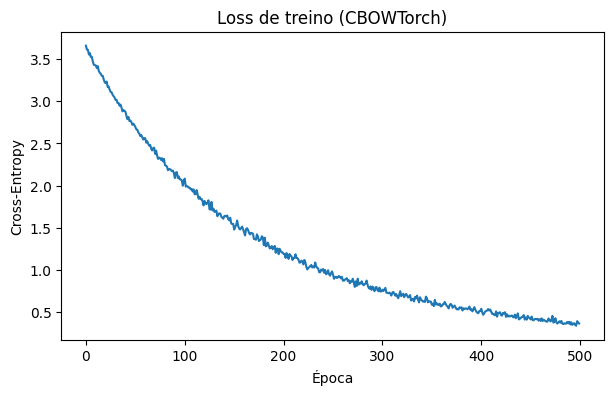

In [11]:
class CBOWTorch(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.proj = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context_ids: torch.Tensor) -> torch.Tensor:
        # context_ids: (B, C)
        emb = self.embedding(context_ids)  # (B, C, D)
        emb_mean = emb.mean(dim=1)  # (B, D)
        logits = self.proj(emb_mean)  # (B, V)
        return logits


def treinar_cbow_torch(
    loader: DataLoader,
    vocab_size: int,
    embedding_dim: int = 20,
    epocas: int = 80,
    lr: float = 0.05,
) -> CBOWTorch:
    """
    Treina um CBoW usando nn.Embedding.

    Retorno:
    -------
    CBOWTorch
        Modelo treinado.
    """
    model = CBOWTorch(vocab_size=vocab_size, embedding_dim=embedding_dim).to(device)
    opt = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    historico = []
    for ep in range(1, epocas + 1):
        model.train()
        loss_total = 0.0

        for ctx, y in loader:
            ctx = ctx.to(device)
            y = y.to(device)

            logits = model(ctx)
            loss = loss_fn(logits, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_total += loss.item()

        loss_med = loss_total / max(1, len(loader))
        historico.append(loss_med)

        if ep % 10 == 0 or ep == 1:
            print(f"Época {ep:03d}/{epocas} | loss médio: {loss_med:.4f}")

    # plot
    plt.figure(figsize=(7, 4))
    plt.plot(historico)
    plt.title("Loss de treino (CBOWTorch)")
    plt.xlabel("Época")
    plt.ylabel("Cross-Entropy")
    plt.show()

    return model


modelo = treinar_cbow_torch(
    loader=loader,
    vocab_size=vocab_size,
    embedding_dim=20,
    epocas=500,
    lr=0.05,
)

## 8) Visualização 2D dos embeddings (PCA)

Vamos pegar embeddings do **vocabulário compacto** e reduzir para 2D. Para não poluir o gráfico, selecionamos só os tokens que casam com algumas palavras de interesse.

In [12]:
new_id_to_token_str

{0: '.',
 1: 'A',
 2: 'O',
 3: 'a',
 4: 'e',
 5: 'o',
 6: ' c',
 7: 'an',
 8: 'or',
 9: ' f',
 10: ' p',
 11: 'ro',
 12: ' g',
 13: 'ce',
 14: ' ch',
 15: ' do',
 16: ' so',
 17: ' ar',
 18: 'ach',
 19: ' no',
 20: ' des',
 21: 'ared',
 22: 'be',
 23: 'ha',
 24: 'ica',
 25: 'ato',
 26: ' tap',
 27: ' da',
 28: ' na',
 29: 'ete',
 30: ' mes',
 31: ' quart',
 32: 'ão'}

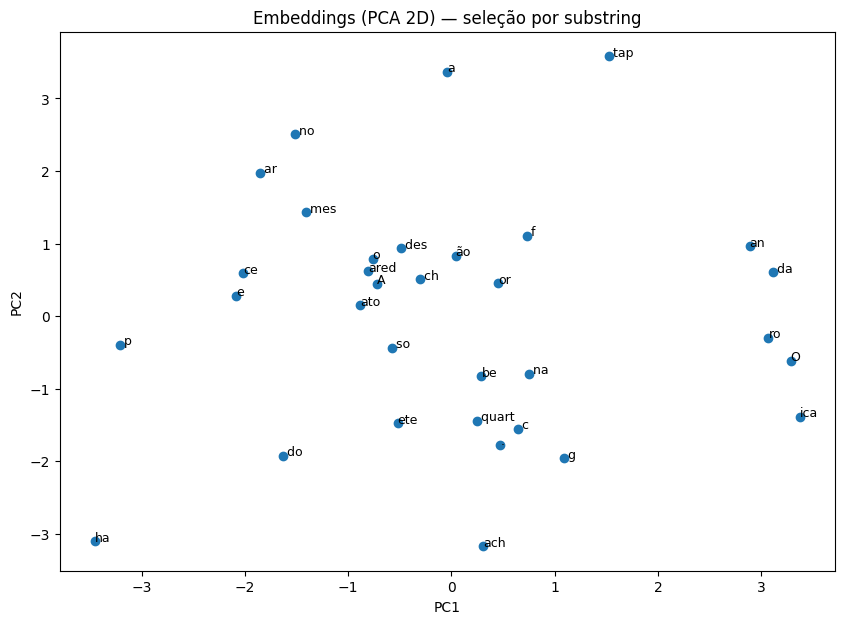

In [13]:
@torch.no_grad()
def get_embedding_matrix(model: CBOWTorch) -> np.ndarray:
    # (V, D)
    return model.embedding.weight.detach().cpu().numpy()


E = get_embedding_matrix(modelo)

ids_sel = list(range(min(60, vocab_size)))

tokens_sel = [new_id_to_token_str[i] for i in ids_sel]
emb_sel = E[ids_sel]

emb_2d = pca_2d(emb_sel)
plot_embeddings_2d(
    tokens_sel,
    emb_2d,
    title="Embeddings (PCA 2D) — seleção por substring",
    max_points=120,
)

## 9) Fenômeno: **média dos embeddings** não enxerga a ordem das palavras (bag-of-words)

Até aqui, o pipeline (tokenização → IDs → `nn.Embedding`) permite extrair um **vetor por token**.

Se você construir um **vetor da frase** apenas fazendo a **média** dos vetores dos tokens (mean pooling),
você cai em uma representação **bag-of-words**: a ordem não importa.

Isso faz com que frases com o mesmo *multiconjunto* de tokens (mesmos tokens, só que permutados) virem
**indistinguíveis** — por exemplo:

- **A**: "O gato sobe no tapete."
- **B**: "O tapete sobe no gato."

Abaixo vamos mostrar:

1. As duas frases têm os **mesmos tokens** (apenas reordenados).
2. A **média** dos embeddings fica (quase) igual.
3. A **similaridade cosseno** fica ~1, então a **distância cosseno** fica ~0.


In [14]:
def cosine_similarity(u: np.ndarray, v: np.ndarray, eps: float = 1e-12) -> float:
    """
    Calcula a similaridade cosseno entre dois vetores.

    Parâmetros:
    ----------
    u, v : np.ndarray
        Vetores 1D.
    eps : float
        Termo para evitar divisão por zero.

    Retorno:
    -------
    float
        Similaridade cosseno no intervalo [-1, 1].
    """
    u = np.asarray(u, dtype=np.float64).ravel()
    v = np.asarray(v, dtype=np.float64).ravel()
    denom = (np.linalg.norm(u) * np.linalg.norm(v)) + eps
    return float(np.dot(u, v) / denom)


def cosine_distance(u: np.ndarray, v: np.ndarray) -> float:
    """
    Distância cosseno (comum em NLP): 1 - similaridade cosseno.
    """
    return 1.0 - cosine_similarity(u, v)


@torch.no_grad()
def frase_para_media_embedding(frase: str) -> dict:
    """
    Converte uma frase para:
      - raw_ids (tiktoken)
      - new_ids (vocabulário compacto do corpus)
      - tokens (string por token)
      - sent_vec (média dos embeddings)

    Observação:
    ----------
    Se a frase contiver tokens que NÃO aparecem no corpus, vai dar KeyError
    no mapeamento raw_id_to_new (porque não existe embedding treinado pra eles aqui).
    """
    raw_ids = tokenizer.encode(frase)
    new_ids = [
        raw_id_to_new[rid] for rid in raw_ids
    ]  # pode dar erro se o token não estiver no corpus

    tokens = [new_id_to_token_str[i] for i in new_ids]

    # matriz de embeddings (V, D)
    E = modelo.embedding.weight.detach().cpu().numpy()
    sent_vec = E[new_ids].mean(axis=0)  # mean pooling → bag-of-words

    return {
        "frase": frase,
        "raw_ids": raw_ids,
        "new_ids": new_ids,
        "tokens": tokens,
        "sent_vec": sent_vec,
    }


frase_A = "O gato sobe no tapete."
frase_B = "O tapete sobe no gato."
frase_C = "O cachorro sobe no tapete."  # frase diferente (do corpus), só pra comparar

A = frase_para_media_embedding(frase_A)
B = frase_para_media_embedding(frase_B)
C = frase_para_media_embedding(frase_C)

print("A tokens:", A["tokens"])
print("B tokens:", B["tokens"])
print(
    "\nMesmo multiconjunto de tokens (A vs B)?",
    sorted(A["tokens"]) == sorted(B["tokens"]),
)

# comparação das médias
delta_AB = np.max(np.abs(A["sent_vec"] - B["sent_vec"]))
print("\nMaior diferença absoluta |A - B| (component-wise):", delta_AB)

# similaridade/distância cosseno
sim_AB = cosine_similarity(A["sent_vec"], B["sent_vec"])
dist_AB = cosine_distance(A["sent_vec"], B["sent_vec"])
print("\ncosine_similarity(A, B):", sim_AB)
print("cosine_distance(A, B):  ", dist_AB)

# comparação com uma frase realmente diferente
sim_AC = cosine_similarity(A["sent_vec"], C["sent_vec"])
dist_AC = cosine_distance(A["sent_vec"], C["sent_vec"])
print("\ncosine_similarity(A, C):", sim_AC)
print("cosine_distance(A, C):  ", dist_AC)

A tokens: ['O', ' g', 'ato', ' so', 'be', ' no', ' tap', 'ete', '.']
B tokens: ['O', ' tap', 'ete', ' so', 'be', ' no', ' g', 'ato', '.']

Mesmo multiconjunto de tokens (A vs B)? True

Maior diferença absoluta |A - B| (component-wise): 5.9604645e-08

cosine_similarity(A, B): 0.9999999999994614
cosine_distance(A, B):   5.385691892456634e-13

cosine_similarity(A, C): 0.8084627491642168
cosine_distance(A, C):   0.1915372508357832


### Interpretação

- Se **A** e **B** têm o mesmo multiconjunto de tokens, então a média dos embeddings é a mesma,
  porque **média é comutativa** (não depende da ordem).
- Por isso, a **similaridade cosseno** entre os vetores de frase fica ~**1** (mesma direção),
  e a **distância cosseno** fica ~**0**.
- Já uma frase que troca um termo importante ("gato" → "cachorro") tende a sair do lugar no espaço,
  então **A vs C** costuma ter similaridade menor (depende do que o embedding aprendeu).